In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import xarray as xr

from osgeo import gdal
#from gistool import rasterize
import pyhdf
from pyhdf.SD import SD
import geopandas as gpd

from scipy import stats
from scipy import integrate
from numpy import exp
import math
from pymannkendall import original_test as mk

import matplotlib as mpl
import matplotlib.pyplot as plt
## set the line width of the hatch
mpl.rcParams['hatch.linewidth'] = 0.5
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import matplotlib.ticker as mticker

In [4]:
gdf = gpd.read_file('D:/LMRB/GRADES-HYDRODL/pfaf_level_02/lmrb.shp')
np.min(gdf['lengthkm'].values)

0.079097740775963

In [2]:
ds = xr.open_dataset('D:/LMRB/GRADES-HYDRODL/output_pfaf_04_1979_202308.nc')
ds1 = xr.open_dataset('D:/LMRB/GRADES-HYDRODL/output_pfaf_04_202309.nc')
gdf = gpd.read_file('D:/LMRB/GRADES-HYDRODL/pfaf_level_02/lmrbcat.shp')
id = gdf['COMID'].values
ds2 = ds['Qout'].sel(rivid=id)
ds3 = ds1['Qout'].sel(rivid=id)
ds3 = ds3.drop_vars(['lon', 'lat'])
array_concat = xr.concat([ds2, ds3], dim='time')
ds4 = array_concat.to_dataset()

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
ds_m = ds4['Qout'].resample(time='M').mean().to_dataset()
ds_m1 = ds_m['Qout'].sel(time=slice('1979-05-31', '2023-04-30')).to_dataset() # since we are talking about hydrological year
hydroyear = pd.date_range('1979-01-31', '2022-12-31', freq='M')
ds_m2 = xr.Dataset({'Qout': (['time','rivid'], ds_m1['Qout'].values)},
                    coords={ 'rivid': (['rivid'], ds_m1.rivid.values),
                            'time': (['time'], hydroyear)})

In [11]:
ds5 = ds_m2.sel(time=ds_m2['time.month'].isin([1,2,3,4,5,6])) # 31+30+31+31+30+31=184 days
ds_wet = ds5.groupby('time.year').mean(dim='time',skipna=True) # wet season mean flow
ds6 = ds_m2.sel(time=ds_m2['time.month'].isin([7,8,9,10,11,12])) # 30+31+31+28+31+30=181 days
ds_dry = ds6.groupby('time.year').mean(dim='time',skipna=True) # dry season mean flow0
ds_annual = ds_m2['Qout'].resample(time='Y').mean().to_dataset()

In [25]:
min_values = ds_m2['Qout'].groupby('time.year').min(dim='time', skipna=True)
# Define a function to find the index of the minimum value along the 'time' dimension
def find_argmin(da):
    return da.argmin(dim='time', skipna=True)
# Apply the function to each group to find the indices of the minimum values
min_indices = ds_m2['Qout'].groupby('time.year').apply(find_argmin)
# Extract the corresponding time values for the minimum indices
min_times = ds_m2['time'].isel(time=min_indices)
# Extract the corresponding month values
min_months = min_times.dt.month
# Combine the results into a Dataset
minmonth = xr.Dataset({
    'min_values': min_values,
    'min_months': min_months
})
minmonth # caution the month here is new hydrological order, should minus 8 when >=9, plus 4 when <=8

<xarray.Dataset>
Dimensions:     (rivid: 18677, year: 44)
Coordinates:
  * rivid       (rivid) int32 44000162 44002058 44004892 ... 44010587 44011792
  * year        (year) int64 1979 1980 1981 1982 1983 ... 2019 2020 2021 2022
    time        (year, rivid) datetime64[ns] 1979-09-30 ... 1979-11-30
Data variables:
    min_values  (year, rivid) float64 0.1576 0.05681 0.7238 ... 398.4 398.6
    min_months  (year, rivid) int64 9 11 10 11 11 11 11 ... 11 11 11 11 11 11 11

In [26]:
date = np.arange(1979,2023)
indi_num = 4
indicator = np.zeros((len(id),indi_num))
for idx, i in enumerate(id):
    v1 = ds_wet['Qout'].sel(rivid=i).values*86400*184             # wet volume, m3
    v2 = ds_dry['Qout'].sel(rivid=i).values*86400*181             # dry volume, m3             
    v3 = ds_annual['Qout'].sel(rivid=i).values*86400*365          # annual volume, m3
    v4 = minmonth['min_values'].sel(rivid=i).values   # annual minima monthly flow, m3/s
    
    long_mean = np.mean(v1)
    mk_tr = mk(v1, alpha=0.05).trend
    mk_p = mk(v1, alpha=0.05).p
    if mk_p<0.05:
        slo = stats.linregress(date,v1).slope/long_mean*100*10 # %/decade (% relative to long time mean)
    else:
        slo = np.nan
    indicator[idx,0] = slo
    
    long_mean = np.mean(v2)
    mk_tr = mk(v2, alpha=0.05).trend
    mk_p = mk(v2, alpha=0.05).p
    if mk_p<0.05:
        slo = stats.linregress(date,v2).slope/long_mean*100*10 # %/decade (% relative to long time mean)
    else:
        slo = np.nan
    indicator[idx,1] = slo
    
    long_mean = np.mean(v3)
    mk_tr = mk(v3, alpha=0.05).trend
    mk_p = mk(v3, alpha=0.05).p
    if mk_p<0.05:
        slo = stats.linregress(date,v3).slope/long_mean*100*10 # %/decade (% relative to long time mean)
    else:
        slo = np.nan
    indicator[idx,2] = slo
    
    long_mean = np.mean(v4)
    mk_tr = mk(v4, alpha=0.05).trend
    mk_p = mk(v4, alpha=0.05).p
    if mk_p<0.05:
        slo = stats.linregress(date,v4).slope/long_mean*100*10 # %/decade (% relative to long time mean)
    else:
        slo = np.nan
    indicator[idx,3] = slo

In [27]:
gdf['wet'] = indicator[:,0]
gdf['dry'] = indicator[:,1]
gdf['annual'] = indicator[:,2]
gdf['minmonth'] = indicator[:,3]
gdf
# gdf.to_file('D:/LMRB/GRADES-HYDRODL/pfaf_level_02/lmrbcat_indicators.shp')

,COMID,unitarea,geometry,wet,dry,annual,minmonth
0,44000162,28.643769,"POLYGON ((96.05399 32.68449, 96.05789 32.68499...",4.315997,NaN,3.126073,-5.458740
1,44002058,32.602310,"POLYGON ((95.50669 32.11459, 95.50349 32.11279...",7.302146,3.454043,6.857496,1.317445
2,44004892,59.460052,"POLYGON ((99.22369 27.43669, 99.21879 27.43629...",NaN,NaN,NaN,NaN
3,44030665,25.602269,"POLYGON ((102.46709 16.99639, 102.46389 16.996...",NaN,NaN,NaN,NaN
4,44034509,104.054963,"POLYGON ((104.35559 15.18079, 104.35379 15.177...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
18672,44010590,1.262795,"POLYGON ((100.32319 22.85659, 100.32429 22.853...",NaN,NaN,NaN,NaN
18673,44010589,12.725260,"POLYGON ((100.32429 22.85329, 100.33239 22.853...",NaN,NaN,NaN,NaN
18674,44010588,52.612906,"POLYGON ((100.39189 22.83589, 100.39299 22.832...",NaN,NaN,NaN,NaN
18675,44010587,1.516501,"POLYGON ((100.37369 22.76129, 100.37539 22.759...",NaN,NaN,NaN,NaN


In [28]:
min(gdf['wet']),max(gdf['wet']),min(gdf['dry']),max(gdf['dry']),min(gdf['annual']),max(gdf['annual']),min(gdf['minmonth']),max(gdf['minmonth'])

(-18.90333423557663,
 29.46118522136015,
 nan,
 nan,
 -18.20932751898364,
 28.819144859799763,
 -15.29711364600059,
 45.15772272566724)

In [40]:
gdf.total_bounds

array([ 93.86089167,   8.57429167, 108.77259167,  33.82499167])

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


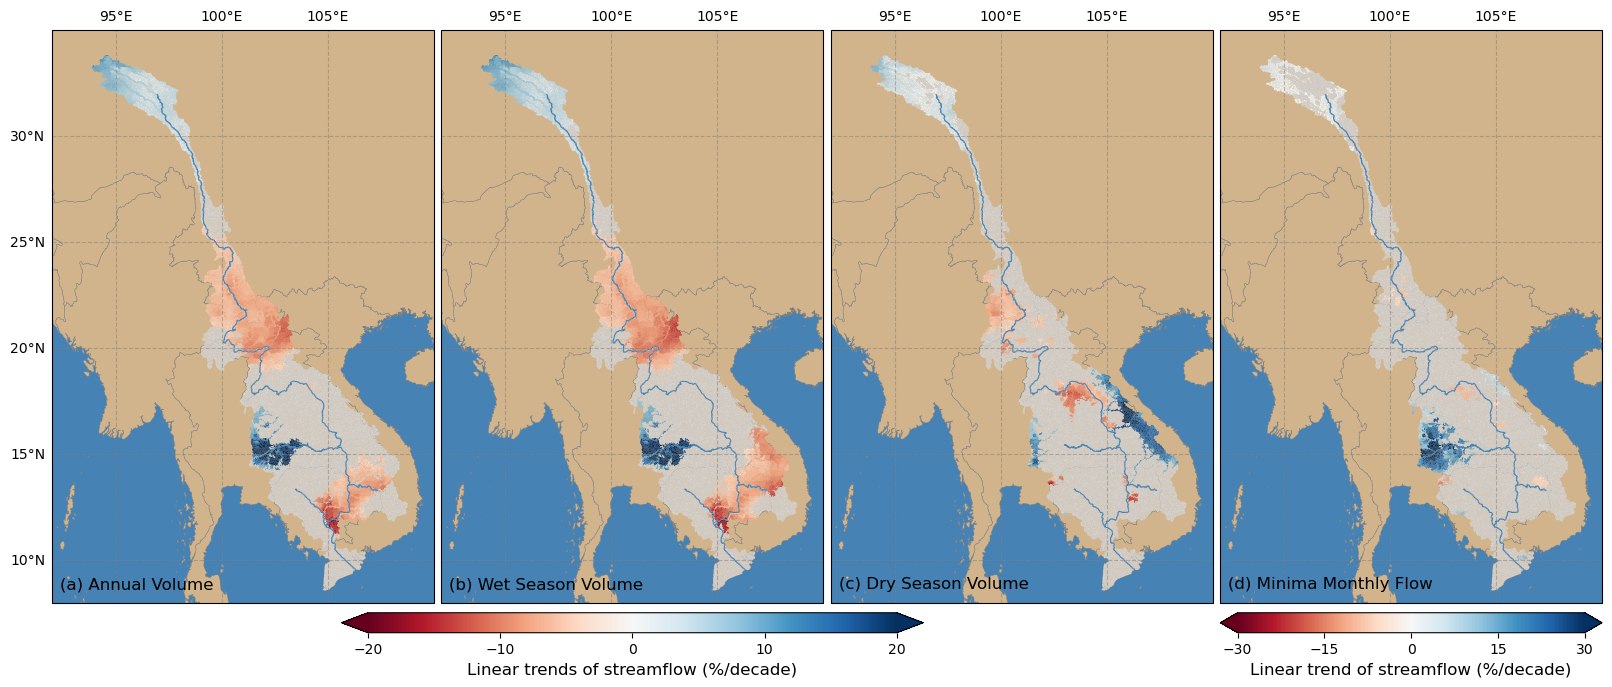

In [138]:
countries = gpd.read_file('D:/LMRB/wb_countries_admin0_10m_china/wb_countries_admin0_10m/WB_countries_Admin0_10m_area.shp')
mainstream = gpd.read_file('D:/LMRB/GRADES-HYDRODL/pfaf_level_02/lmrb.shp')
projection = ccrs.PlateCarree()
fig, axes = plt.subplots(1,4,figsize=(20,20),subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.02)  # Adjust these values as needed

countries.plot(ax=axes[0], facecolor='tan', edgecolor='gray', linewidth=0.3)
mainstream_6 = mainstream[mainstream['order_'] >= 6]
mainstream_6.plot(ax=axes[0], facecolor='none', edgecolor='steelblue', linewidth=0.8)
gdf.plot(ax=axes[0], column='annual', legend=False, cmap='RdBu',missing_kwds={
        "color": "lightgray"},vmin=-20, vmax=20)

countries.plot(ax=axes[1], facecolor='tan', edgecolor='gray', linewidth=0.3)
mainstream_6.plot(ax=axes[1], facecolor='none', edgecolor='steelblue', linewidth=0.8)
gdf.plot(ax=axes[1], column='wet', legend=False, cmap='RdBu',missing_kwds={
        "color": "lightgray"},vmin=-20, vmax=20)

countries.plot(ax=axes[2], facecolor='tan', edgecolor='gray', linewidth=0.3)
mainstream_6.plot(ax=axes[2], facecolor='none', edgecolor='steelblue', linewidth=0.8)
gdf.plot(ax=axes[2], column='dry', legend=False, cmap='RdBu',missing_kwds={
        "color": "lightgray"},vmin=-20, vmax=20)

countries.plot(ax=axes[3], facecolor='tan', edgecolor='gray', linewidth=0.3)
mainstream_6.plot(ax=axes[3], facecolor='none', edgecolor='steelblue', linewidth=0.8)
gdf.plot(ax=axes[3], column='minmonth', legend=False, cmap='RdBu',missing_kwds={
        "color": "lightgray"},vmin=-30, vmax=30)


extent = [92, 110, 8, 35]
for ax in axes:
        ax.set_extent(extent, crs=projection)
        ax.set_facecolor('steelblue')
gl = axes[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.8, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([95,100,105])
gl.ylocator = mticker.FixedLocator([10, 15, 20, 25, 30])
for ax in axes[1:]:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.8, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_bottom = False
        gl.ylabels_right = False
        gl.ylabels_left = False
        gl.xlocator = mticker.FixedLocator([95,100,105])

ticks = list(np.linspace(-20, 20, 5))
norm = mpl.colors.Normalize(vmin=-20, vmax=20)
pos = axes[1].get_position()
pad = 0.01*1.5
height = 0.005 * 2
bottom_side = pos.ymin - pad
cax = fig.add_axes([pos.xmin-0.05, bottom_side, (pos.xmax - pos.xmin+0.1), height])
cbar = mpl.colorbar.ColorbarBase(cax, cmap='RdBu', norm=norm, extend='both', orientation='horizontal')
cbar.ax.set_xlabel('Linear trends of streamflow (%/decade)', fontsize=12)
cbar.set_ticks(ticks)
ticks = list(np.linspace(-30, 30, 5))
norm = mpl.colors.Normalize(vmin=-30, vmax=30)
pos = axes[3].get_position()
pad = 0.01*1.5
height = 0.005 * 2
bottom_side = pos.ymin - pad
cax = fig.add_axes([pos.xmin, bottom_side, (pos.xmax - pos.xmin), height])
cbar = mpl.colorbar.ColorbarBase(cax, cmap='RdBu', norm=norm, extend='both', orientation='horizontal')
cbar.ax.set_xlabel('Linear trend of streamflow (%/decade)', fontsize=12)
cbar.set_ticks(ticks)

subplot_names = ['(a) Annual Volume', '(b) Wet Season Volume', '(c) Dry Season Volume', '(d) Minima Monthly Flow']
for ax, name in zip(axes.flatten(), subplot_names):
        ax.text(0.02, 0.02, name, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='left')

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_ri

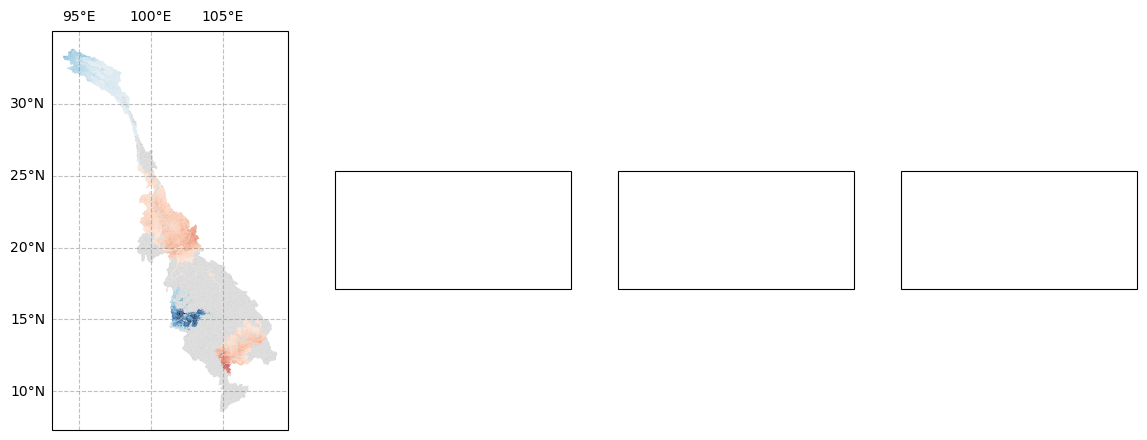

In [87]:
projection = ccrs.PlateCarree()
fig, axes = plt.subplots(1,4,figsize=(14,14),subplot_kw={'projection': ccrs.PlateCarree()})
gdf.plot(ax=axes[0], column='annual', legend=False, cmap='RdBu',missing_kwds={
        "color": "lightgray"},vmin=-25, vmax=25)
# gdf.plot(ax=axes[1], column='wet', legend=False, cmap='RdBu',missing_kwds={
#         "color": "lightgray"},vmin=-25, vmax=25)
# gdf.plot(ax=axes[2], column='dry', legend=False, cmap='RdBu',missing_kwds={
#         "color": "lightgray"},vmin=-25, vmax=25)
# gdf.plot(ax=axes[3], column='minmonth', legend=False, cmap='RdBu',missing_kwds={
#         "color": "lightgray"},vmin=-30, vmax=30)
gl = axes[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.8, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = True
gl.ylabels_left = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([95,100,105])
gl.ylocator = mticker.FixedLocator([10, 15, 20, 25, 30])

In [139]:
ds4

<xarray.Dataset>
Dimensions:  (rivid: 18677, time: 16344)
Coordinates:
  * rivid    (rivid) int32 44000162 44002058 44004892 ... 44010587 44011792
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2023-09-30
Data variables:
    Qout     (time, rivid) float64 0.1697 0.07947 0.5687 ... 2.709e+03 2.711e+03

In [151]:
ds7 = ds4['Qout'].sel(time=slice('1979-05-01', '2023-04-30')).to_dataset()
ds8 = ds7.sel(time=~((ds7['time'].dt.month == 2) & (ds7['time'].dt.day == 29)))
hydroday = np.arange(0,16060)
ds_d = xr.Dataset({'Qout': (['num','rivid'], ds8['Qout'].values)},
                    coords={ 'rivid': (['rivid'], ds8.rivid.values),
                            'num': (['num'], hydroday)})
ds_d

<xarray.Dataset>
Dimensions:  (num: 16060, rivid: 18677)
Coordinates:
  * rivid    (rivid) int32 44000162 44002058 44004892 ... 44010587 44011792
  * num      (num) int32 0 1 2 3 4 5 6 ... 16054 16055 16056 16057 16058 16059
Data variables:
    Qout     (num, rivid) float64 0.3142 0.07901 2.644 ... 526.8 527.0 527.1

In [172]:
gdf

,COMID,unitarea,geometry,wet,dry,annual,minmonth
0,44000162,28.643769,"POLYGON ((96.05399 32.68449, 96.05789 32.68499...",4.315997,NaN,3.126073,-5.458740
1,44002058,32.602310,"POLYGON ((95.50669 32.11459, 95.50349 32.11279...",7.302146,3.454043,6.857496,1.317445
2,44004892,59.460052,"POLYGON ((99.22369 27.43669, 99.21879 27.43629...",NaN,NaN,NaN,NaN
3,44030665,25.602269,"POLYGON ((102.46709 16.99639, 102.46389 16.996...",NaN,NaN,NaN,NaN
4,44034509,104.054963,"POLYGON ((104.35559 15.18079, 104.35379 15.177...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
18672,44010590,1.262795,"POLYGON ((100.32319 22.85659, 100.32429 22.853...",NaN,NaN,NaN,NaN
18673,44010589,12.725260,"POLYGON ((100.32429 22.85329, 100.33239 22.853...",NaN,NaN,NaN,NaN
18674,44010588,52.612906,"POLYGON ((100.39189 22.83589, 100.39299 22.832...",NaN,NaN,NaN,NaN
18675,44010587,1.516501,"POLYGON ((100.37369 22.76129, 100.37539 22.759...",NaN,NaN,NaN,NaN


In [176]:
per5 = 5
per10 = 10
date = np.arange(1979,2023)
indi_num = 2
indicator1 = np.zeros((len(id),indi_num))
for idx,i in enumerate(id):
    new = np.zeros((365,44))
    percentile = np.zeros(44)
    for j in range(0,44):
        new[:,j] = ds_d['Qout'].sel(rivid=i).values[j*365:j*365+365]
        percentile[j] = np.percentile(new[:,j],per5)
    long_mean = np.mean(percentile)
    mk_tr = mk(percentile, alpha=0.05).trend
    mk_p = mk(percentile, alpha=0.05).p
    if mk_p<0.05:
        slo = stats.linregress(date,percentile).slope/long_mean*100*10 # %/decade (% relative to long time mean)
    else:
        slo = np.nan
    indicator1[idx,0] = slo
    
    new = np.zeros((365,44))
    percentile = np.zeros(44)
    for j in range(0,44):
        new[:,j] = ds_d['Qout'].sel(rivid=i).values[j*365:j*365+365]
        percentile[j] = np.percentile(new[:,j],per10)
    long_mean = np.mean(percentile)
    mk_tr = mk(percentile, alpha=0.05).trend
    mk_p = mk(percentile, alpha=0.05).p
    if mk_p<0.05:
        slo = stats.linregress(date,percentile).slope/long_mean*100*10 # %/decade (% relative to long time mean)
    else:
        slo = np.nan
    indicator1[idx,1] = slo

In [177]:
gdf['per5'] = indicator1[:,0]
gdf['per10'] = indicator1[:,1]
gdf

,COMID,unitarea,geometry,wet,dry,annual,minmonth,per5,per10
0,44000162,28.643769,"POLYGON ((96.05399 32.68449, 96.05789 32.68499...",4.315997,NaN,3.126073,-5.458740,-5.689687,-4.974530
1,44002058,32.602310,"POLYGON ((95.50669 32.11459, 95.50349 32.11279...",7.302146,3.454043,6.857496,1.317445,1.323017,1.426445
2,44004892,59.460052,"POLYGON ((99.22369 27.43669, 99.21879 27.43629...",NaN,NaN,NaN,NaN,NaN,NaN
3,44030665,25.602269,"POLYGON ((102.46709 16.99639, 102.46389 16.996...",NaN,NaN,NaN,NaN,17.953056,NaN
4,44034509,104.054963,"POLYGON ((104.35559 15.18079, 104.35379 15.177...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
18672,44010590,1.262795,"POLYGON ((100.32319 22.85659, 100.32429 22.853...",NaN,NaN,NaN,NaN,NaN,NaN
18673,44010589,12.725260,"POLYGON ((100.32429 22.85329, 100.33239 22.853...",NaN,NaN,NaN,NaN,NaN,NaN
18674,44010588,52.612906,"POLYGON ((100.39189 22.83589, 100.39299 22.832...",NaN,NaN,NaN,NaN,NaN,NaN
18675,44010587,1.516501,"POLYGON ((100.37369 22.76129, 100.37539 22.759...",NaN,NaN,NaN,NaN,NaN,NaN


In [185]:
date = np.arange(1979,2023)
indi_num = 2
indicator2 = np.zeros((len(id),indi_num))
for idx,i in enumerate(id):
    new = np.zeros((365,44))
    percentile = np.zeros(44)
    for j in range(0,44):
        new[:,j] = ds_d['Qout'].sel(rivid=i).values[j*365:j*365+365]
        moving = pd.Series(new[:, j]).rolling(window=7, center=True).mean()
        percentile[j] = np.min(moving)
    long_mean = np.mean(percentile)
    mk_tr = mk(percentile, alpha=0.05).trend
    mk_p = mk(percentile, alpha=0.05).p
    if mk_p<0.05:
        slo = stats.linregress(date,percentile).slope/long_mean*100*10 # %/decade (% relative to long time mean)
    else:
        slo = np.nan
    indicator2[idx,0] = slo
    
    new = np.zeros((365,44))
    percentile = np.zeros(44)
    for j in range(0,44):
        new[:,j] = ds_d['Qout'].sel(rivid=i).values[j*365:j*365+365]
        moving = pd.Series(new[:, j]).rolling(window=30, center=True).mean()
        percentile[j] = np.min(moving)
    long_mean = np.mean(percentile)
    mk_tr = mk(percentile, alpha=0.05).trend
    mk_p = mk(percentile, alpha=0.05).p
    if mk_p<0.05:
        slo = stats.linregress(date,percentile).slope/long_mean*100*10 # %/decade (% relative to long time mean)
    else:
        slo = np.nan
    indicator2[idx,1] = slo

In [186]:
gdf['7d'] = indicator2[:,0]
gdf['30d'] = indicator2[:,1]
gdf

,COMID,unitarea,geometry,wet,dry,annual,minmonth,per5,per10,7d,30d
0,44000162,28.643769,"POLYGON ((96.05399 32.68449, 96.05789 32.68499...",4.315997,NaN,3.126073,-5.458740,-5.689687,-4.974530,-6.046634,-5.716703
1,44002058,32.602310,"POLYGON ((95.50669 32.11459, 95.50349 32.11279...",7.302146,3.454043,6.857496,1.317445,1.323017,1.426445,1.285056,1.225453
2,44004892,59.460052,"POLYGON ((99.22369 27.43669, 99.21879 27.43629...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44030665,25.602269,"POLYGON ((102.46709 16.99639, 102.46389 16.996...",NaN,NaN,NaN,NaN,17.953056,NaN,17.838197,19.351218
4,44034509,104.054963,"POLYGON ((104.35559 15.18079, 104.35379 15.177...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.505678
...,...,...,...,...,...,...,...,...,...,...,...
18672,44010590,1.262795,"POLYGON ((100.32319 22.85659, 100.32429 22.853...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18673,44010589,12.725260,"POLYGON ((100.32429 22.85329, 100.33239 22.853...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18674,44010588,52.612906,"POLYGON ((100.39189 22.83589, 100.39299 22.832...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18675,44010587,1.516501,"POLYGON ((100.37369 22.76129, 100.37539 22.759...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [187]:
min(gdf['per5']),max(gdf['per5']),min(gdf['per10']),max(gdf['per10']),min(gdf['7d']),max(gdf['7d']),min(gdf['30d']),max(gdf['30d'])

(-11.73963110144401,
 88.53645621297844,
 -12.243092410796073,
 62.46494106181429,
 -16.788311617416362,
 103.44693918039177,
 -19.34947305125315,
 49.498086252977885)

c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
c:\Users\bn_li\.conda\envs\LBN\lib\site-packages\cartopy\mpl\gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


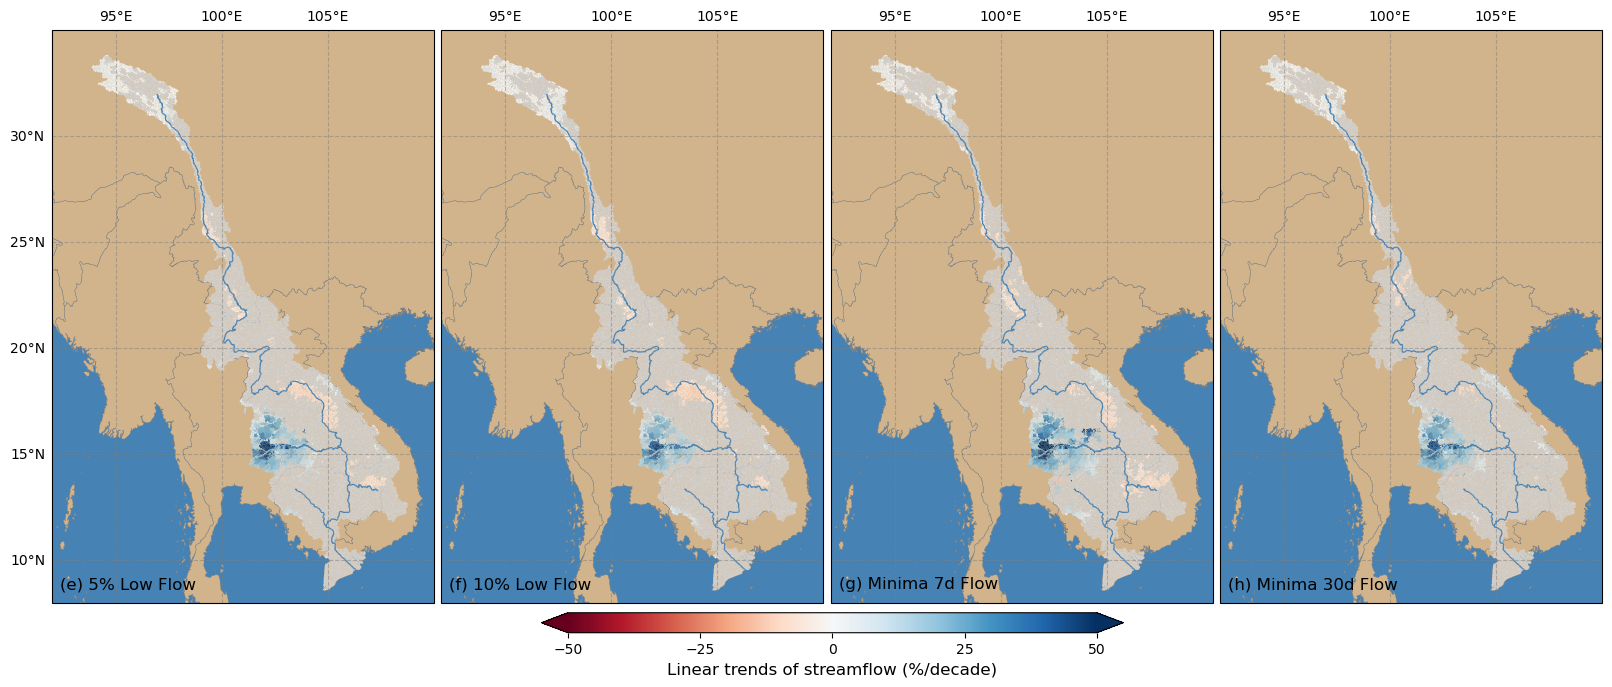

In [194]:
countries = gpd.read_file('D:/LMRB/wb_countries_admin0_10m_china/wb_countries_admin0_10m/WB_countries_Admin0_10m_area.shp')
mainstream = gpd.read_file('D:/LMRB/GRADES-HYDRODL/pfaf_level_02/lmrb.shp')
projection = ccrs.PlateCarree()
fig, axes = plt.subplots(1,4,figsize=(20,20),subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.02)  # Adjust these values as needed

countries.plot(ax=axes[0], facecolor='tan', edgecolor='gray', linewidth=0.3)
mainstream_6 = mainstream[mainstream['order_'] >= 6]
mainstream_6.plot(ax=axes[0], facecolor='none', edgecolor='steelblue', linewidth=0.8)
gdf.plot(ax=axes[0], column='per5', legend=False, cmap='RdBu',missing_kwds={
        "color": "lightgray"},vmin=-50, vmax=50)

countries.plot(ax=axes[1], facecolor='tan', edgecolor='gray', linewidth=0.3)
mainstream_6.plot(ax=axes[1], facecolor='none', edgecolor='steelblue', linewidth=0.8)
gdf.plot(ax=axes[1], column='per10', legend=False, cmap='RdBu',missing_kwds={
        "color": "lightgray"},vmin=-50, vmax=50)

countries.plot(ax=axes[2], facecolor='tan', edgecolor='gray', linewidth=0.3)
mainstream_6.plot(ax=axes[2], facecolor='none', edgecolor='steelblue', linewidth=0.8)
gdf.plot(ax=axes[2], column='7d', legend=False, cmap='RdBu',missing_kwds={
        "color": "lightgray"},vmin=-50, vmax=50)

countries.plot(ax=axes[3], facecolor='tan', edgecolor='gray', linewidth=0.3)
mainstream_6.plot(ax=axes[3], facecolor='none', edgecolor='steelblue', linewidth=0.8)
gdf.plot(ax=axes[3], column='30d', legend=False, cmap='RdBu',missing_kwds={
        "color": "lightgray"},vmin=-50, vmax=50)


extent = [92, 110, 8, 35]
for ax in axes:
        ax.set_extent(extent, crs=projection)
        ax.set_facecolor('steelblue')
gl = axes[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.8, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([95,100,105])
gl.ylocator = mticker.FixedLocator([10, 15, 20, 25, 30])
for ax in axes[1:]:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.8, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_bottom = False
        gl.ylabels_right = False
        gl.ylabels_left = False
        gl.xlocator = mticker.FixedLocator([95,100,105])

ticks = list(np.linspace(-50, 50, 5))
norm = mpl.colors.Normalize(vmin=-50, vmax=50)
pos = axes[1].get_position()
pad = 0.01*1.5
height = 0.005 * 2
bottom_side = pos.ymin - pad
cax = fig.add_axes([pos.xmin+0.05, bottom_side, (pos.xmax - pos.xmin+0.1), height])
cbar = mpl.colorbar.ColorbarBase(cax, cmap='RdBu', norm=norm, extend='both', orientation='horizontal')
cbar.ax.set_xlabel('Linear trends of streamflow (%/decade)', fontsize=12)
cbar.set_ticks(ticks)
# ticks = list(np.linspace(-30, 30, 5))
# norm = mpl.colors.Normalize(vmin=-30, vmax=30)
# pos = axes[3].get_position()
# pad = 0.01*1.5
# height = 0.005 * 2
# bottom_side = pos.ymin - pad
# cax = fig.add_axes([pos.xmin, bottom_side, (pos.xmax - pos.xmin), height])
# cbar = mpl.colorbar.ColorbarBase(cax, cmap='RdBu', norm=norm, extend='both', orientation='horizontal')
# cbar.ax.set_xlabel('Linear trend of streamflow (%/decade)', fontsize=12)
# cbar.set_ticks(ticks)

subplot_names = ['(e) 5% Low Flow', '(f) 10% Low Flow', '(g) Minima 7d Flow', '(h) Minima 30d Flow']
for ax, name in zip(axes.flatten(), subplot_names):
        ax.text(0.02, 0.02, name, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='left')

In [192]:
gdf.to_file('D:/LMRB/GRADES-HYDRODL/pfaf_level_02/lmrbcat_indicators.shp')